In [1]:
%%capture
%pip install nflfastpy 

In [2]:
import nflfastpy as nfl
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

plt.style.use('seaborn-talk')
plt.style.use('ggplot')

# Data Collection

pull nflfastR data from the [nflfastR-data](https://github.com/guga31bb/nflfastR-data) 
repository and concatenate the seperate, yearly DataFrames in to a single DataFrame.

In [3]:
data = pd.DataFrame()

for i, season in enumerate(range(1999, 2021)):
    yearly_data = nfl.load_pbp_data(season)
    yearly_data['season'] = season
    data = pd.concat([data, yearly_data])

# Calculating EPA

For our features, we will be using exponentially weighted rolling EPA. For those who don't know what EPA is - it stands for estimated points added, and is a statistic that quantifies how many points a particular play added to a team's score. It's based on a lot of things - field position, yards gained, down and distance, etc. and is generally a good way to quantify and measure offensive and defensive efficiency/performance. A 30 yard play on 3rd and 13, for example, might have 3.2 estimated points added.

We will be taking average EPA per play for each team (split in to rushing, passing, and then further split in to defense, offense) for each week and then calculating a moving average (we will also lag the data back one period, so we only use data up to and not including a particular game). Moreover, instead of calculating a simple moving average, we will be calculating a exponential moving average, which will weigh more recent games more heavily.

EPA will be split in to defense and offense for both teams, and then further split in to passing and rushing.

In [4]:
def dynamic_window_ewma(x):
    """
    Calculate rolling exponentially weighted EPA with a dynamic window size
    """
    values = np.zeros(len(x))
    for i, (_, row) in enumerate(x.iterrows()):
        epa = x.epa_shifted[:i+1]
        if row.week > 10:
            values[i] = epa.ewm(min_periods=1, span=row.week).mean().values[-1]
        else:
            values[i] = epa.ewm(min_periods=1, span=10).mean().values[-1]
            
    return pd.Series(values, index=x.index)

# seperate EPA in to rushing offense, rushing defense, passing offense, passing defense for each team
rushing_offense_epa = data.loc[data['rush_attempt'] == 1, :]\
.groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

rushing_defense_epa = data.loc[data['rush_attempt'] == 1, :]\
.groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_offense_epa = data.loc[data['pass_attempt'] == 1, :]\
.groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_defense_epa = data.loc[data['pass_attempt'] == 1, :]\
.groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

# lag EPA one period back
rushing_offense_epa['epa_shifted'] = rushing_offense_epa.groupby('posteam')['epa'].shift()
rushing_defense_epa['epa_shifted'] = rushing_defense_epa.groupby('defteam')['epa'].shift()
passing_offense_epa['epa_shifted'] = passing_offense_epa.groupby('posteam')['epa'].shift()
passing_defense_epa['epa_shifted'] = passing_defense_epa.groupby('defteam')['epa'].shift()

# In each case, calculate EWMA with a static window and dynamic window and assign it as a column 
rushing_offense_epa['ewma'] = rushing_offense_epa.groupby('posteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_offense_epa['ewma_dynamic_window'] = rushing_offense_epa.groupby('posteam')\
.apply(dynamic_window_ewma).values

rushing_defense_epa['ewma'] = rushing_defense_epa.groupby('defteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_defense_epa['ewma_dynamic_window'] = rushing_defense_epa.groupby('defteam')\
.apply(dynamic_window_ewma).values

passing_offense_epa['ewma'] = passing_offense_epa.groupby('posteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_offense_epa['ewma_dynamic_window'] = passing_offense_epa.groupby('posteam')\
.apply(dynamic_window_ewma).values

passing_defense_epa['ewma'] = passing_defense_epa.groupby('defteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_defense_epa['ewma_dynamic_window'] = passing_defense_epa.groupby('defteam')\
.apply(dynamic_window_ewma).values

#Merge all the data together
offense_epa = rushing_offense_epa.merge(passing_offense_epa, on=['posteam', 'season', 'week'], suffixes=('_rushing', '_passing'))\
.rename(columns={'posteam': 'team'})
defense_epa = rushing_defense_epa.merge(passing_defense_epa, on=['defteam', 'season', 'week'], suffixes=('_rushing', '_passing'))\
.rename(columns={'defteam': 'team'})
epa = offense_epa.merge(defense_epa, on=['team', 'season', 'week'], suffixes=('_offense', '_defense'))

#remove the first season of data
epa = epa.loc[epa['season'] != epa['season'].unique()[0], :]

epa = epa.reset_index(drop=True)

epa.head()

NumExpr defaulting to 8 threads.


,team,season,week,epa_rushing_offense,epa_shifted_rushing_offense,ewma_rushing_offense,ewma_dynamic_window_rushing_offense,epa_passing_offense,epa_shifted_passing_offense,ewma_passing_offense,ewma_dynamic_window_passing_offense,epa_rushing_defense,epa_shifted_rushing_defense,ewma_rushing_defense,ewma_dynamic_window_rushing_defense,epa_passing_defense,epa_shifted_passing_defense,ewma_passing_defense,ewma_dynamic_window_passing_defense
0,ARI,2000,1,-0.345669,-0.068545,-0.109518,-0.109518,0.019830,0.056256,-0.172588,-0.172588,0.166199,0.363190,0.086016,0.086016,-0.009200,0.269840,0.115978,0.115978
1,ARI,2000,2,-0.276743,-0.345669,-0.153920,-0.153920,0.558977,0.019830,-0.136410,-0.136410,-0.065981,0.166199,0.101092,0.101092,0.283460,-0.009200,0.092441,0.092441
2,ARI,2000,4,-0.334533,-0.276743,-0.176871,-0.176871,-0.264054,0.558977,-0.006468,-0.006468,-0.018524,-0.065981,0.069872,0.069872,0.500345,0.283460,0.128136,0.128136
3,ARI,2000,5,-0.016838,-0.334533,-0.206184,-0.206184,0.049141,-0.264054,-0.054359,-0.054359,0.004625,-0.018524,0.053437,0.053437,0.058499,0.500345,0.197339,0.197339
4,ARI,2000,6,-0.038473,-0.016838,-0.171124,-0.171124,0.101830,0.049141,-0.035195,-0.035195,0.086308,0.004625,0.044399,0.044399,-0.063633,0.058499,0.171631,0.171631


# Plotting EPA

We can plot EPA for the Dolphins alongside our moving averages. We can see that the static window EMA and dynamic window EMA are quite similar, with slight divergences towards season ends.

Text(0.5, 1.0, 'MIA Passing EPA per play')

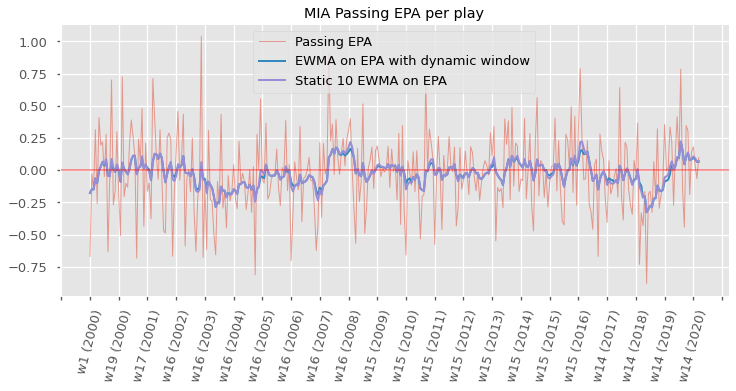

In [15]:
tm = epa.loc[epa['team'] == 'MIA', :].assign(
    season_week = lambda x: 'w' + x.week.astype(str) + ' (' + x.season.astype(str) + ')'
).set_index('season_week')

fig, ax = plt.subplots(figsize=(12, 5))

loc = plticker.MultipleLocator(base=16) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.tick_params(axis='x', rotation=75) #rotate the x-axis labels a bit

ax.plot(tm['epa_shifted_passing_offense'], lw=1, alpha=0.5)
ax.plot(tm['ewma_dynamic_window_passing_offense'], lw=2)
ax.plot(tm['ewma_passing_offense'], lw=2)
plt.axhline(y=0, color='red', lw=1.5, alpha=0.5)

ax.legend(['Passing EPA', 'EWMA on EPA with dynamic window', 'Static 10 EWMA on EPA'])
ax.set_title('MIA Passing EPA per play')

# Defining Target 

Now that we have our features, we can add target variables through including game results.

In [6]:
schedule = data[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']]\
.drop_duplicates().reset_index(drop=True)\
.assign(home_team_win = lambda x: (x.home_score > x.away_score).astype(int))

df = schedule.merge(epa.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week'])\
.merge(epa.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], suffixes=('_home', '_away'))

df.head()

,season,week,home_team,away_team,home_score,away_score,home_team_win,epa_rushing_offense_home,epa_shifted_rushing_offense_home,ewma_rushing_offense_home,...,ewma_passing_offense_away,ewma_dynamic_window_passing_offense_away,epa_rushing_defense_away,epa_shifted_rushing_defense_away,ewma_rushing_defense_away,ewma_dynamic_window_rushing_defense_away,epa_passing_defense_away,epa_shifted_passing_defense_away,ewma_passing_defense_away,ewma_dynamic_window_passing_defense_away
0,2000,1,NYG,ARI,21,16,1,0.166199,0.162852,-0.105274,...,-0.172588,-0.172588,0.166199,0.363190,0.086016,0.086016,-0.009200,0.269840,0.115978,0.115978
1,2000,1,PIT,BAL,0,16,0,-0.499352,-0.643877,-0.117606,...,-0.115063,-0.115063,-0.499352,-0.241927,-0.205927,-0.205927,-0.216112,-0.314740,-0.201637,-0.201637
2,2000,1,WAS,CAR,20,17,1,-0.006129,-0.390855,-0.060330,...,0.187536,0.187536,-0.006129,0.060270,0.057299,0.057299,0.147979,-0.368611,0.001226,0.001226
3,2000,1,MIN,CHI,30,27,1,0.283000,-0.163698,-0.066504,...,-0.079538,-0.079538,0.283000,-0.130394,-0.057451,-0.057451,0.124496,0.365886,0.105317,0.105317
4,2000,1,LA,DEN,41,36,1,-0.106372,-0.692095,-0.259090,...,-0.018102,-0.018102,-0.106372,-0.110182,-0.091645,-0.091645,0.400226,-0.078273,-0.086851,-0.086851


In [7]:
target = 'home_team_win'
features = [column for column in df.columns if 'ewma' in column and 'dynamic' in column]
features

['ewma_dynamic_window_rushing_offense_home',
 'ewma_dynamic_window_passing_offense_home',
 'ewma_dynamic_window_rushing_defense_home',
 'ewma_dynamic_window_passing_defense_home',
 'ewma_dynamic_window_rushing_offense_away',
 'ewma_dynamic_window_passing_offense_away',
 'ewma_dynamic_window_rushing_defense_away',
 'ewma_dynamic_window_passing_defense_away']

# Model Training and Testing 

We see our week model has about a 63.5% accuracy score.

In [8]:
df = df.dropna()

X = df.loc[df['season'] != 2020, features].values
y = df.loc[df['season'] != 2020, target].values

clf = LogisticRegression()
clf.fit(X, y)

accuracy_scores = cross_val_score(clf, X, y, cv=10)
log_losses = cross_val_score(clf, X, y, cv=10, scoring='neg_log_loss')

print('Model Accuracy:', np.mean(accuracy_scores))
print('Neg log loss:', np.mean(log_losses))


Model Accuracy: 0.633718560002257
Neg log loss: -0.6383735341002159


Text(0.5, 1.0, 'Feature importance')

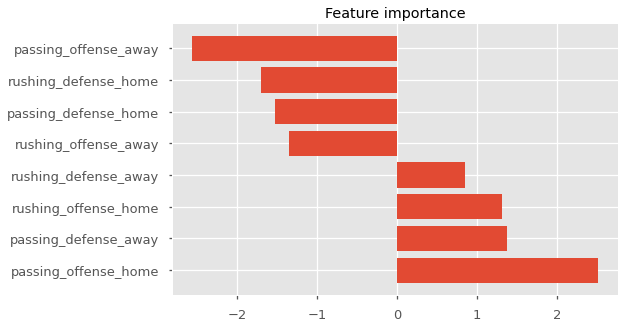

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))

feature_names = ['_'.join(feature_name.split('_')[3:]) for feature_name in features]

coef_ = clf.coef_[0]

features_coef_sorted = sorted(zip(feature_names, coef_), key=lambda x:x[-1], reverse=True)

features_sorted = [feature for feature, _ in features_coef_sorted]
coef_sorted = [coef for _, coef in features_coef_sorted]

ax.barh(features_sorted, coef_sorted);
ax.set_title('Feature importance')

# Model Performance 

Something fun we can do now is see how the model would have predicted this past season. Notice we took out 2020 data from our training data, and so now we are free to see how the model would have done in 2020 (since none of the 2020 data was used for training).

These are the 10 games this season the model was most confident about. No surprises here that the KC-NYJ game was the most lopsided game this season.

We can also view how our model would have done this season by week. There doesn't seem to be a clear trend here. You would expect that the model would get better as the season went on, but the data doesn't make that clear here.

In [10]:
df_2020 = df.loc[(df['season'] == 2020)].assign(
    predicted_winner = lambda x: clf.predict(x[features]),
    home_team_win_probability = lambda x: clf.predict_proba(x[features])[:, 1]
)\
[['home_team', 'away_team', 'week', 'predicted_winner', 'home_team_win_probability', 'home_team_win']]

df_2020['actual_winner'] = df_2020.apply(lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
df_2020['predicted_winner'] = df_2020.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
df_2020['win_probability'] = df_2020.apply(lambda x: x.home_team_win_probability if x.predicted_winner == x.home_team else 1 - x.home_team_win_probability, axis=1)
df_2020['correct_prediction'] = (df_2020['predicted_winner'] == df_2020['actual_winner']).astype(int)

df_2020 = df_2020.drop(columns=['home_team_win_probability', 'home_team_win'])

df_2020.sort_values(by='win_probability', ascending=False).reset_index(drop=True).head(10)


C:\Users\17866\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\17866\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
0,KC,NYJ,8,KC,KC,0.874632,1
1,KC,DEN,13,KC,KC,0.847304,1
2,LA,NYJ,15,LA,NYJ,0.832521,0
3,LA,NYG,4,LA,LA,0.832395,1
4,SF,PHI,4,SF,PHI,0.818946,0
5,MIA,NYJ,6,MIA,MIA,0.803181,1
6,KC,CAR,9,KC,KC,0.795523,1
7,BAL,CLE,1,BAL,BAL,0.794969,1
8,BAL,CIN,5,BAL,BAL,0.779975,1
9,IND,JAX,17,IND,IND,0.773537,1


In [16]:
correct = df_2020.loc[df_2020['correct_prediction'] == 1].groupby('week')['correct_prediction'].sum()

num_games = df_2020.groupby('week')['correct_prediction'].size()

results = correct / num_games

results.head(20)

week
1     0.750000
2     0.875000
3     0.500000
4     0.733333
5     0.714286
6     0.571429
7     0.714286
8     0.571429
9     0.500000
10    0.785714
11    0.714286
12    0.687500
13    0.466667
14    0.562500
15    0.687500
16    0.687500
17    0.750000
18    0.666667
19    0.750000
20    0.500000
Name: correct_prediction, dtype: float64

In [12]:
# superbowl prediction
df_2020.loc[df_2020['week'] == results.idxmax()].sort_values(by='win_probability', ascending=False)

,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
5590,TB,KC,21,TB,TB,0.579106,1


In [13]:
# playoff predictions 
df_2020.loc[df_2020['week'] > 17]

,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
5578,TEN,BAL,18,BAL,BAL,0.552014,1
5579,NO,CHI,18,NO,NO,0.754811,1
5580,PIT,CLE,18,PIT,CLE,0.514621,0
5581,BUF,IND,18,BUF,BUF,0.632828,1
5582,SEA,LA,18,SEA,LA,0.589411,0
...,...,...,...,...,...,...,...
5586,GB,LA,19,GB,GB,0.690255,1
5587,NO,TB,19,NO,TB,0.596848,0
5588,KC,BUF,20,KC,KC,0.532748,1
5589,GB,TB,20,GB,TB,0.593928,0
